# Guía 4

Nombre estudiante: Pablo Gómez Paredes  
Nombre profesor: David Medina Ortiz  
Asignatura: Matemáticas para Ciencias de la Computación  
Fecha entrega: 28/11/2025

## 1.1) Introducción: Colección, preparación y justificación del dataset escogido

En la presente guía se analizará un dataset referente a los datos históricos del tiempo en Punta Arenas, abarcando el período desde el 1 de septiembre hasta el 31 de octubre del presente año.  Los descriptores incluidos corresponden principalmente a temperatura, velocidad del viento y presión atmosférica.

La etiqueta _(label)_ que se analizará en función de estos descriptores será un valor binario (0 o 1) construido específicamente para este análisis, indicando si en un día determinado hubo precipitación (1) o no la hubo (0).  Esta decisión permitirá simplificar el análisis, y centrar la exploración estadística en la ocurrencia del fenómeno y en qué factores pueden hacer más probable que ocurra ese fenómeno, más que en su intensidad.

Este dataset se escogió principalmente porque permite trabajar con datos reales, recientes y que además son más de mi interés analizar.   Y por otra parte, también porque el clima de Punta Arenas presenta condiciones particularmente dinámicas —con fuertes variaciones de viento, cambios bruscos de temperatura y frecuencia de precipitaciones— lo que genera un conjunto de datos estadísticamente interesante para estudiar asociaciones y patrones.

Para la obtención del dataset, hubo que instalar la librería _meteostat_ a través del comando pip install.  Esta librería facilita el acceso a registros metereológicos de estaciones oficiales y permite descargar datos fácilmente transformables para su posterior análisis.

In [1]:
# Inclusión de librerías necesarias
from meteostat import Daily, Point
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from umap import UMAP
from datetime import datetime
from auxiliar_functions import *

In [2]:
# Coordenadas de Punta Arenas
punta_arenas = Point(-53.155877, -70.901687)

In [3]:
# Rango de fechas
start = datetime(2025, 9, 1)
end = datetime(2025, 10, 31)

In [4]:
# Descarga de los datos
data = Daily(punta_arenas, start, end)
df = data.fetch()

## 1.2) Descripción de metadatos y composición del dataset (descripción general y descripción de variables)

En las siguientes celdas se hará el código que permitirá describir los metadatos y la composición del dataset, y también luego se explicará.

In [5]:
# Primeras filas del dataset
df.head(10)

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
time,,,,,,,,,,
2025-09-01,4.0,1.0,7.0,0.4,<NA>,<NA>,31.7,<NA>,1001.1,<NA>
2025-09-02,1.4,-1.0,4.0,0.0,<NA>,<NA>,33.2,<NA>,996.5,<NA>
2025-09-03,2.4,-1.0,5.0,0.0,<NA>,<NA>,33.8,<NA>,1014.6,<NA>
2025-09-04,5.9,3.0,9.0,0.0,<NA>,<NA>,27.1,<NA>,1022.4,<NA>
2025-09-05,7.4,5.0,10.0,0.4,<NA>,<NA>,36.2,<NA>,1016.2,<NA>
2025-09-06,6.8,5.0,10.0,0.0,<NA>,<NA>,33.8,<NA>,1011.9,<NA>
2025-09-07,6.3,4.0,10.0,0.0,<NA>,<NA>,35.6,<NA>,1006.1,<NA>
2025-09-08,5.4,2.0,9.0,0.4,<NA>,<NA>,19.5,<NA>,1010.7,<NA>
2025-09-09,5.2,4.0,6.0,3.6,<NA>,<NA>,29.0,<NA>,1003.5,<NA>


In [6]:
# Tamaño del dataset
df.shape

(61, 10)

In [7]:
# Tipos de metadatos
df.dtypes

tavg    Float64
tmin    Float64
tmax    Float64
prcp    Float64
snow    Float64
wdir    Float64
wspd    Float64
wpgt    Float64
pres    Float64
tsun    Float64
dtype: object

El dataset en su forma original contiene 61 ejemplos y 10 descriptores, todos del tipo numérico, los cuales podrán actuar como variables predictoras en el análisis. Estos descriptores son:

* tavg: La temperatura media de un día (°C).
* tmin: La temperatura mínima alcanzada durante un día (°C).
* tmax: La temperatura máxima alcanzada durante un día (°C).
* prcp: La precipitación durante un día (mm)._
* snow: La precipitación en forma de nieve durante un día (mm).
* wdir: Dirección del viento (°).
* wspd: Rapidez media del viento durante un día (km/h).
* wpgt: Rapidez máxima de las rachas de viento (km/h).
* pres: Presión atmosférica media a nivel del mar (hPa).
* tsun: Horas de sol diarias (h).

Nota: Incluso podrían ser 11 descriptores si consideramos también a la fecha como un descriptor más.

El dataset no incluye originalmente una etiqueta _(label)_ para realizar análisis.  Por este motivo, y dado que el objetivo de la guía es investigar asociaciones entre descriptores y un fenómeno de interés, se generará una nueva etiqueta binaria basada en la ocurrencia de precipitación.  Específicamente, la columna prcp será recodificada para producir una variable 0/1 que indique si en un día determinado hubo lluvia (1) o no la hubo (0).

Al observar los descriptores, también se aprecia a simple vista que algunos presentan una cantidad importante de valores faltantes. Para evaluar su impacto, se realizará un recuento formal de datos nulos por columna. Como criterio general — común en análisis exploratorio — si un descriptor presenta más de un 30% de valores faltantes, la columna será eliminada debido a su baja utilidad informativa. En caso de porcentajes menores, y si la variable resulta relevante para el análisis, sus valores faltantes se imputarán mediante la mediana, considerando que se trata de variables numéricas potencialmente afectadas por asimetría.

Cabe destacar que, al tratarse de datos meteorológicos históricos, sería posible completar los valores faltantes consultando registros de otras estaciones meteorológicas. Sin embargo, dicha reconstrucción iría más allá del propósito de esta guía, cuyo objetivo es practicar análisis exploratorio y tratamiento estadístico de datos tal como se presentan.

## 2.1) EDA - Parte I: Identificación de nulos y resumen estadístico.

En las siguientes celdas se hará el análisis de los datos nulos y cómo tratarlos, y también un resumen estadístico.  En esta sección ya se tendrá el dataset definitivo que se utilizará para hacer lo que sigue.

In [8]:
# Se genera el recuento de nulos para cada uno de los descriptores
df_count_nulls = generate_df_count_nulls(df=df)
df_count_nulls

,count_nulls,pct_nulls
tavg,0,0.0
tmin,0,0.0
tmax,0,0.0
prcp,0,0.0
snow,61,100.0
wdir,61,100.0
wspd,0,0.0
wpgt,61,100.0
pres,0,0.0
tsun,61,100.0


In [9]:
columns_to_delete =  []

# Se eliminan las columnas que tienen al menos un 30% de datos nulos, en caso contrario habría que hacer imputación por medio de la mediana
for row in df_count_nulls.index:
    if df_count_nulls["pct_nulls"][row] >= 30.0:
        columns_to_delete.append(row)

df = df.drop(columns=columns_to_delete)

df.head(10)  # Se muestran las primeras filas (registros) del dataset

,tavg,tmin,tmax,prcp,wspd,pres
time,,,,,,
2025-09-01,4.0,1.0,7.0,0.4,31.7,1001.1
2025-09-02,1.4,-1.0,4.0,0.0,33.2,996.5
2025-09-03,2.4,-1.0,5.0,0.0,33.8,1014.6
2025-09-04,5.9,3.0,9.0,0.0,27.1,1022.4
2025-09-05,7.4,5.0,10.0,0.4,36.2,1016.2
2025-09-06,6.8,5.0,10.0,0.0,33.8,1011.9
2025-09-07,6.3,4.0,10.0,0.0,35.6,1006.1
2025-09-08,5.4,2.0,9.0,0.4,19.5,1010.7
2025-09-09,5.2,4.0,6.0,3.6,29.0,1003.5


In [10]:
df = df.rename(columns={"prcp": "mm"})
df["prcp"] = df["mm"].apply(lambda x: 0 if x == 0.0 else 1)  # Aquí se genera el label (originalmente no venía)
df = df.drop(columns=["mm"])
df

,tavg,tmin,tmax,wspd,pres,prcp
time,,,,,,
2025-09-01,4.0,1.0,7.0,31.7,1001.1,1
2025-09-02,1.4,-1.0,4.0,33.2,996.5,0
2025-09-03,2.4,-1.0,5.0,33.8,1014.6,0
2025-09-04,5.9,3.0,9.0,27.1,1022.4,0
2025-09-05,7.4,5.0,10.0,36.2,1016.2,1
...,...,...,...,...,...,...
2025-10-27,6.5,-2.0,15.0,9.8,1024.2,0
2025-10-28,8.2,4.0,12.0,11.9,1011.8,1
2025-10-29,11.4,8.0,16.0,27.6,1006.7,1


In [11]:
# Verificamos que el dataset nuevo no tiene datos nulos
new_df_count_nulls = generate_df_count_nulls(df=df)
new_df_count_nulls

,count_nulls,pct_nulls
tavg,0,0.0
tmin,0,0.0
tmax,0,0.0
wspd,0,0.0
pres,0,0.0
prcp,0,0.0


### Explicación del nuevo dataset

El dataset nuevo ahora tiene solo 6 variables: 5 predictivas que son numéricas y continuas (tavg, tmin, tmax, wspd y pres) y 1 variable binaria que está actuando como _label_ (prcp).

Ahora, como se puede apreciar también, el dataset ya no tiene ningún dato nulo.


### Resumen estadístico

In [12]:
# Descriptores numéricos reales
predictors = df[["tavg", "tmin", "tmax", "wspd", "pres"]]

df_descriptive = predictors.describe().T
df_descriptive = df_descriptive.apply(pd.to_numeric, errors='coerce')
df_descriptive["mean"] = df_descriptive["mean"].round(2)
df_descriptive["std"] = df_descriptive["std"].round(2)
df_descriptive


,count,mean,std,min,25%,50%,75%,max
tavg,61.0,6.13,2.02,1.4,4.8,6.4,7.2,11.4
tmin,61.0,2.77,2.35,-3.0,1.0,3.0,4.0,8.0
tmax,61.0,9.89,2.69,4.0,8.0,10.0,11.0,17.0
wspd,61.0,26.08,7.71,8.0,20.1,27.1,32.1,41.7
pres,61.0,1001.12,11.03,973.0,993.5,999.3,1009.2,1024.8


In [13]:
df["prcp"].value_counts()

prcp
1    42
0    19
Name: count, dtype: int64

### 2.1.1) Análisis de estadística descriptiva

Se presenta la **tabla de estadísticas descriptivas** de las variables numéricas, que incluye medidas de tendencia central y dispersión. A partir de estos valores se observa que la temperatura media (`tavg`), mínima (`tmin`) y máxima (`tmax`) presentan un nivel de variabilidad similar, y que es leve a moderado, mientras que la velocidad del viento (`wspd`) presenta una mayor variabilidad. La **presión atmosférica (`pres`)** muestra valores en torno a un promedio estable. Estos indicadores sirven de referencia para entender la magnitud y variabilidad de cada descriptor.

Por otro lado, la variable objetivo `prcp` (lluvia/no lluvia) no está balanceada, ya que tiene una mayoría de días con precipitación. Este desequilibrio moderado deberá tenerse en cuenta en análisis posteriores.

## 2.2) EDA - Parte II: Identificación de _outliers_

In [14]:
# Se hace un data frame para los rangos de los outliers
df_outlier_ranges = pd.DataFrame(columns=["min", "max"])

for var in predictors:
    q1 = df_descriptive["25%"][var]
    q3 = df_descriptive["75%"][var]
    IQR = q3 - q1
    min_val, max_val = get_range_outlier(q1, q3, IQR)
    df_outlier_ranges.loc[var, "min"] = min_val
    df_outlier_ranges.loc[var, "max"] = max_val

df_outlier_ranges


,min,max
tavg,1.2,10.8
tmin,-3.5,8.5
tmax,3.5,15.5
wspd,2.1,50.1
pres,969.95,1032.75


In [15]:
# Creamos el DataFrame vacío con las columnas que queremos
outlier_summary = pd.DataFrame(columns=["n_outliers", "pct_outliers"])

for var in predictors:
    # Límites inferior y superior del rango "no outlier"
    low = df_outlier_ranges.loc[var, "min"]
    high = df_outlier_ranges.loc[var, "max"]
    
    # Máscara booleana para detectar outliers
    mask_outliers = (df[var] < low) | (df[var] > high)
    
    # Cantidad y porcentaje de outliers
    n_out = mask_outliers.sum()
    pct_out = (n_out / len(df)) * 100
    
    # Guardamos en una fila cuyo índice es el nombre de la variable
    outlier_summary.loc[var, "n_outliers"] = n_out
    outlier_summary.loc[var, "pct_outliers"] = round(pct_out, 2)

outlier_summary


,n_outliers,pct_outliers
tavg,2,3.28
tmin,0,0.0
tmax,2,3.28
wspd,0,0.0
pres,0,0.0


## 3.1) Decisión sobre _outliers_

Como se pudo observar en la sección anterior, solo hay 4 _outliers_ en total en el dataset: 2 de ellos corresponden a la variable tavg y los otros 2 a la variable tmax, de modo que las demás variables no poseen ningún _outlier_.

Además, las dos variables que sí poseen _outliers_ tienen un porcentaje bajo de de datos atípicos: solo un 3.28%.

Al ser bajo el porcentaje de _outliers_, la decisión de momento será de conservar esos _outliers_, pero para confirmarlo, a continuación se hallarán exactamente cuáles son los registros que contienen esos datos atípicos, y se analizarán sus valores, para tomar la decisión final.

In [16]:
rows = []

for var in predictors:
    low = df_outlier_ranges.loc[var, "min"]
    high = df_outlier_ranges.loc[var, "max"]
    mask_outliers = (df[var] < low) | (df[var] > high)

    for idx in df.index[mask_outliers]:
        rows.append({
            "variable": var,
            "index": idx,
            "value": df.loc[idx, var]
        })

df_outlier_detail = pd.DataFrame(rows)
df_outlier_detail


,variable,index,value
0,tavg,2025-10-29,11.4
1,tavg,2025-10-30,11.2
2,tmax,2025-10-29,16.0
3,tmax,2025-10-30,17.0


### Decisión final

Al ver que los valores no se alejan demasiado del mínimo valor para _outlier_ grande, se tomará la decisión de mantener esos _outliers_.

Esta decisión se tomará, sobre todo teniendo en cuenta que representan días inusualmente cálidos pero dentro de lo esperado para días lindos de fines de octubre en Punta Arenas.

## 3.2) Síntesis de la exploración de nulos y outliers

La exploración de datos permitió identificar que el dataset **no presenta valores nulos** en las variables seleccionadas luego del preprocesamiento. Con respecto a los outliers, se detectaron **cuatro valores atípicos** distribuidos en las variables de temperatura y viento. Dado que estos valores se encuentran cerca de los límites de dispersión y su influencia sobre la media es mínima, se decidió **mantenerlos** en el análisis.  Esta decisión preserva la información y evita eliminar días potencialmente representativos de condiciones extremas.

En conclusión, tras la limpieza inicial el conjunto de datos queda conformado por 61 observaciones y 6 variables (5 predictoras y el `label` de precipitación), listo para las etapas de visualización y reducción de dimensionalidad.

## 4.1) Visualización estadística y matrices de correlación

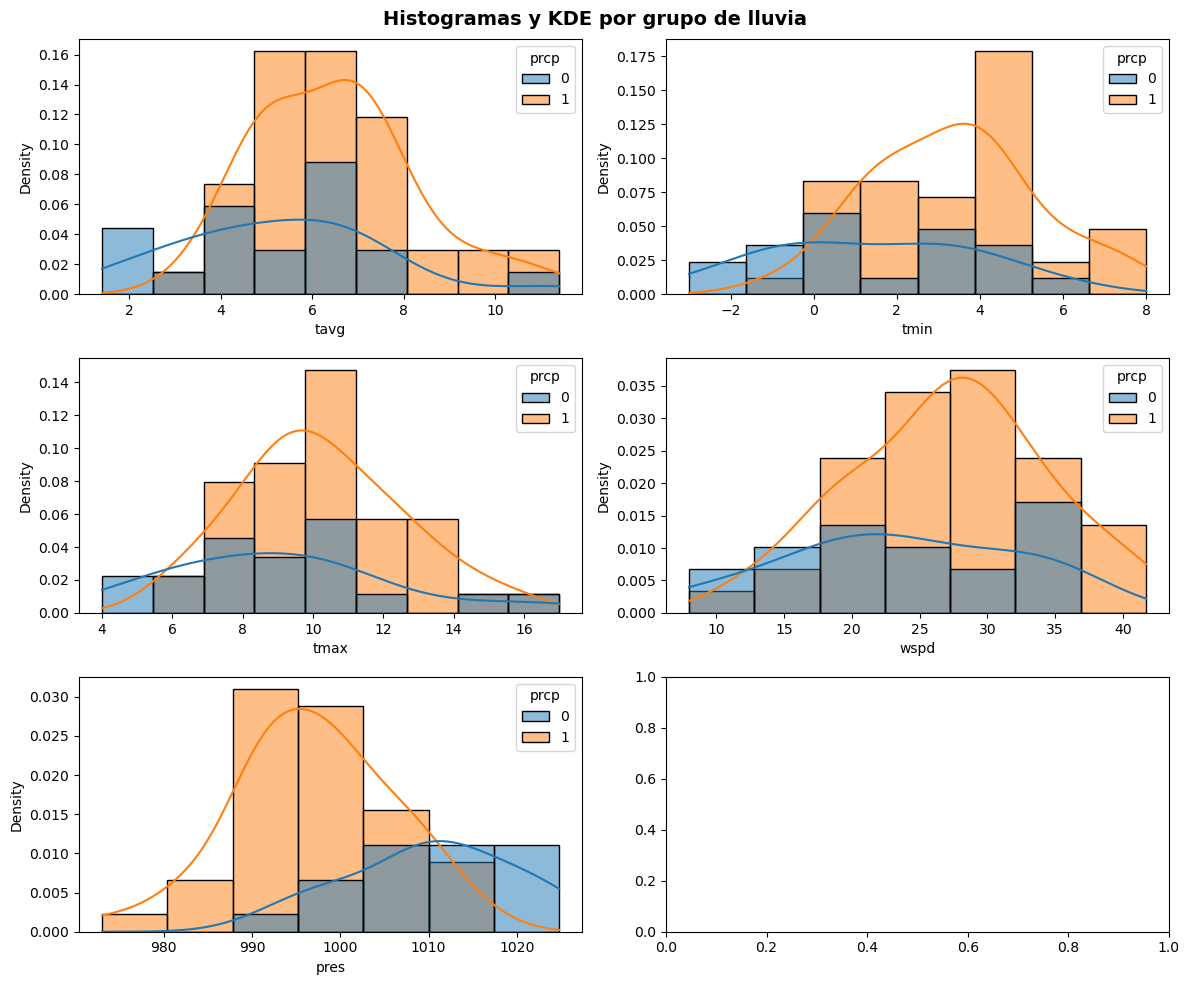

In [17]:
cols = predictors

fig, axis = plt.subplots(3, 2, figsize=(12, 10))
i = j = 0

for column in cols:
    sns.histplot(
        data=df,
        x=column,
        stat="density",
        kde=True,
        hue="prcp",  # 0 = no lluvia, 1 = lluvia
        ax=axis[i][j]
    )
    axis[i][j].set_xlabel(column)
    j += 1
    if j > 1:
        j = 0
        i += 1

plt.suptitle("Histogramas y KDE por grupo de lluvia", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


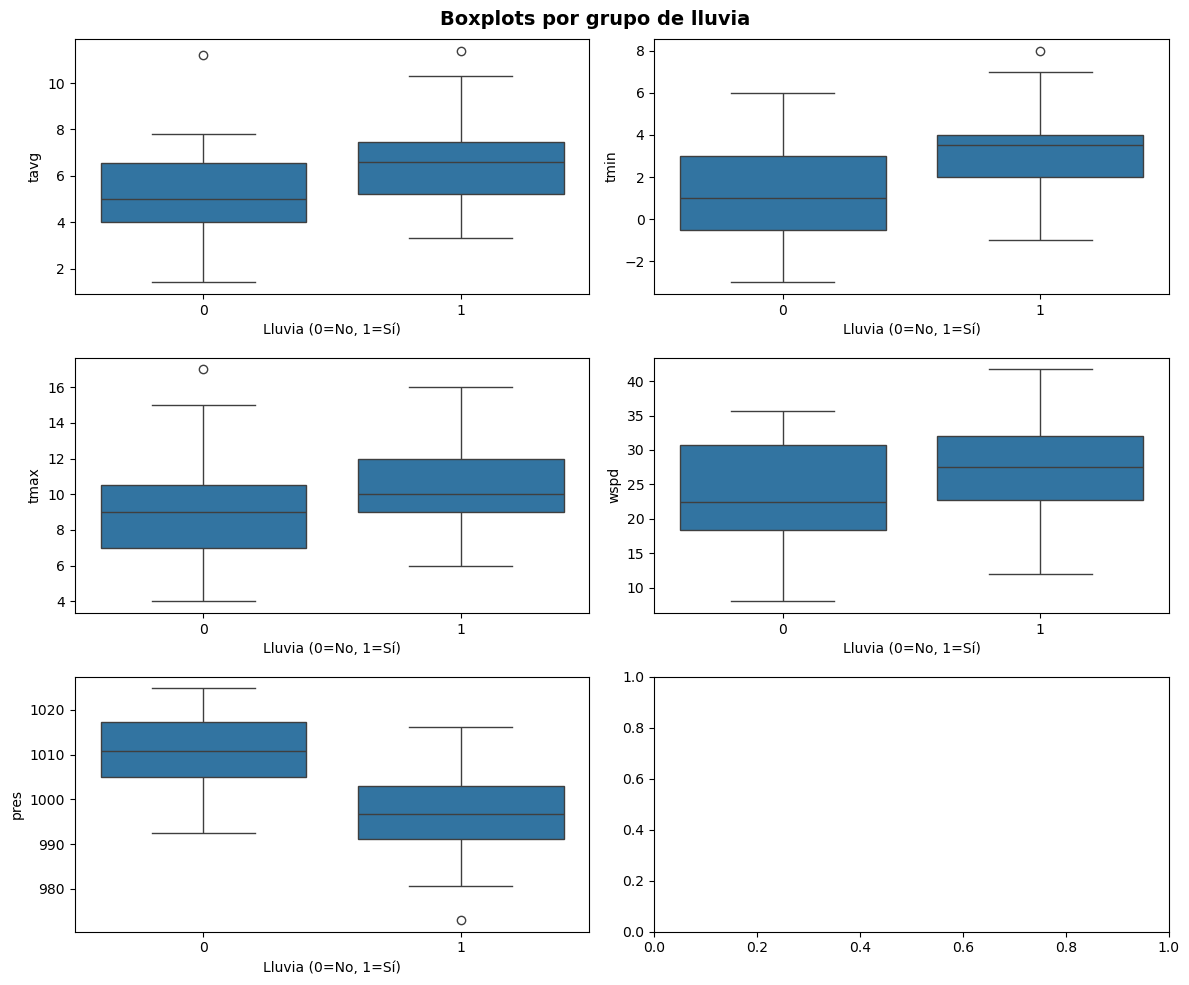

In [18]:
fig, axis = plt.subplots(3, 2, figsize=(12, 10))
i = j = 0

for column in cols:
    sns.boxplot(
        data=df,
        x="prcp",
        y=column,
        ax=axis[i][j]
    )
    axis[i][j].set_xlabel("Lluvia (0=No, 1=Sí)")
    axis[i][j].set_ylabel(column)
    j += 1
    if j > 1:
        j = 0
        i += 1

plt.suptitle("Boxplots por grupo de lluvia", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


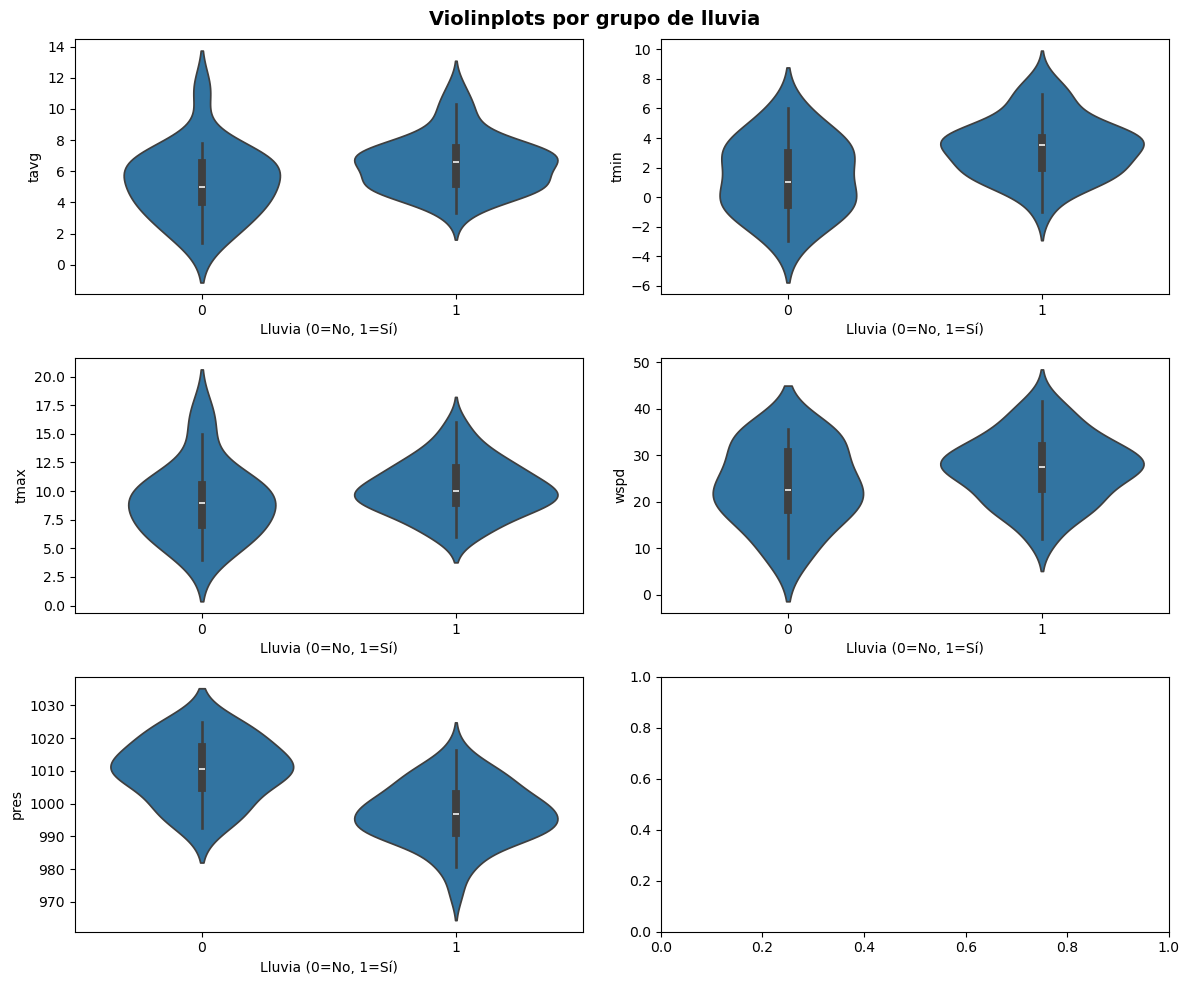

In [19]:
fig, axis = plt.subplots(3, 2, figsize=(12, 10))
i = j = 0

for column in cols:
    sns.violinplot(
        data=df,
        x="prcp",
        y=column,
        ax=axis[i][j]
    )
    axis[i][j].set_xlabel("Lluvia (0=No, 1=Sí)")
    axis[i][j].set_ylabel(column)
    j += 1
    if j > 1:
        j = 0
        i += 1

plt.suptitle("Violinplots por grupo de lluvia", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


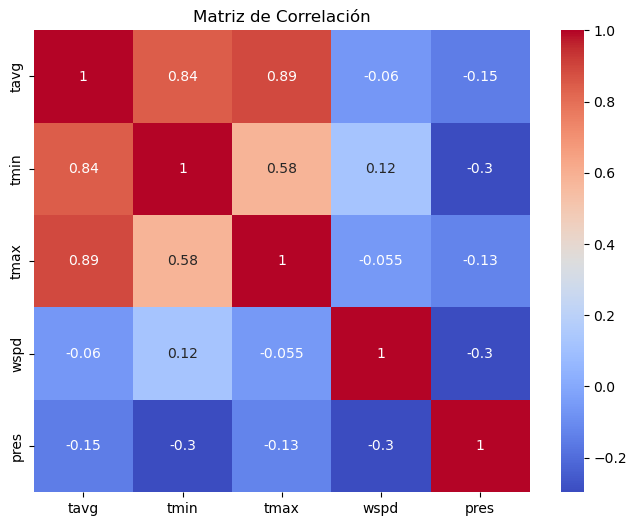

In [20]:
plt.figure(figsize=(8, 6))
sns.heatmap(predictors.corr(), annot=True, cmap="coolwarm")
plt.title("Matriz de Correlación")
plt.show()



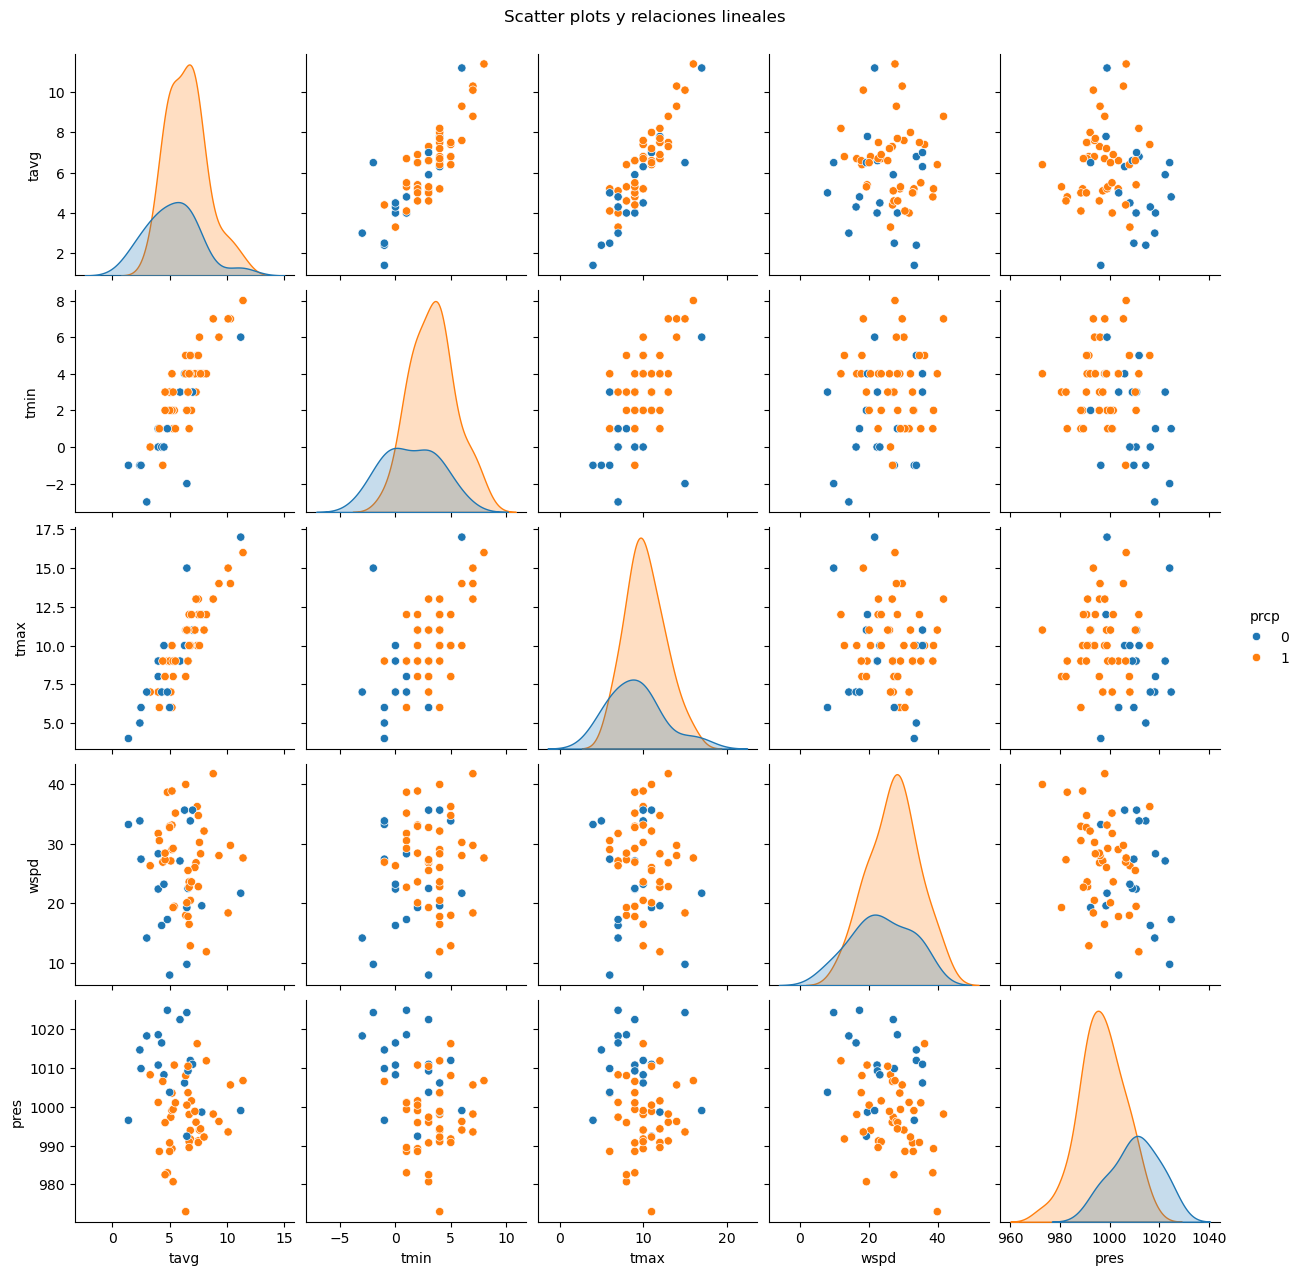

In [21]:
predictor_cols = predictors.columns.tolist()

sns.pairplot(df[predictor_cols + ["prcp"]], hue="prcp")
plt.suptitle("Scatter plots y relaciones lineales", y=1.02)
plt.show()



## 4.2) Interpretación de las visualizaciones

Los **histogramas** muestran que las variables de temperatura presentan distribuciones aproximadamente normales, mientras que la velocidad del viento exhibe una distribución más asimétrica con presencia de valores extremos, lo cual es coherente con su naturaleza meteorológica. Los **boxplots** y **violinplots**, segmentados por la etiqueta prcp, indican que, en general, la mayoría de los descriptores no difieren radicalmente entre días con y sin precipitación. Sin embargo, sí se observaron algunos patrones interesantes:

* El viento tendió a ser ligeramente mayor en días lluviosos que en días no lluviosos: Esto llama la atención, ya que muchas veces la gente de la zona asume que la lluvia reduce la intensidad del viento. En este caso, el dataset sugiere lo contrario, lo que pudo deberse a sistemas frontales que combinaron ambas condiciones.
* Las temperaturas mínimas tendieron a ser un poco más altas en días lluviosos (~4°C) que en días no lluviosos (~1°C): Esto es especialmente revelador, ya que coincide con el comportamiento atmosférico esperado: los días lluviosos suelen presentar cielos cubiertos, lo que durante la noche - periodo en el cual suelen presentarse las temperaturas mínimas - actúa como una “capa” que reduce la pérdida de calor por radiación.
* La presión atmosférica en días lluviosos tendió a ser más baja: Esto en metereología es bastante consistente, ya que normalmente las altas presiones vienen acompañadas de cielos despejados.

La **matriz de correlación** refleja una fuerte correlación positiva entre las tres variables de temperatura y una correlación negativa moderada entre la presión y la velocidad del viento. El **pairplot** confirma que las relaciones entre descriptores son en gran parte lineales y que no existe una separación clara entre los valores del label, sugiriendo que la clasificación basándose en estas variables podría ser compleja. Estas observaciones motivan el uso de técnicas de reducción de dimensionalidad para entender mejor la estructura interna del dataset.

## 5.1) Preparación de datos, aplicación de PCA y código de varianza explicada

In [22]:
# Subdataframes
y = df["prcp"].values
X = df.drop(columns=["prcp"])

scaler = StandardScaler()
X_scaler = scaler.fit_transform(X)

pca_instance = PCA(n_components=3, random_state=42)
pca_instance.fit(X_scaler)
pca_instance.transform(X_scaler)

array([[-1.61685613e+00,  8.51384874e-01,  2.76039907e-01],
       [-3.38738957e+00,  1.61744854e+00, -1.43404974e-01],
       [-3.21719890e+00,  4.68258759e-01,  1.18708722e+00],
       [-5.86532009e-01, -1.05025647e+00,  1.47246029e+00],
       [ 6.98982512e-01,  5.02215358e-02,  1.99734722e+00],
       [ 5.86840401e-01,  1.22164312e-01,  1.47562960e+00],
       [ 3.17787259e-01,  6.35143724e-01,  1.20719234e+00],
       [-7.91616729e-01, -1.08573746e+00, -1.71681805e-02],
       [-8.10920307e-01,  5.36533485e-01,  2.76055065e-01],
       [-1.21279958e+00, -1.48622793e+00, -1.59080723e+00],
       [ 5.49872558e-02, -9.73803324e-01, -2.58772425e-01],
       [ 4.95688438e-01, -7.38361024e-01, -9.99398989e-01],
       [ 1.50423687e+00, -2.56837471e-02, -7.65333378e-01],
       [ 1.13877891e+00,  5.49650617e-02, -1.22447668e-01],
       [-7.66765275e-01,  6.17518815e-01, -2.96045575e-01],
       [-2.22146457e+00, -5.17653070e-02,  2.23401241e-01],
       [-1.75399380e+00, -5.53802169e-01

In [23]:
pca_instance.n_components_

3

In [24]:
pca_instance.explained_variance_ratio_

array([0.52387209, 0.26054498, 0.13467278])

In [25]:
sum(pca_instance.explained_variance_ratio_)

np.float64(0.9190898515315439)

In [26]:
df_matrix_pca = pd.DataFrame(data=pca_instance.transform(X_scaler), columns=["p_" + str(i) for i in range(pca_instance.n_components_)])
df_matrix_pca

,p_0,p_1,p_2
0,-1.616856,0.851385,0.276040
1,-3.387390,1.617449,-0.143405
2,-3.217199,0.468259,1.187087
3,-0.586532,-1.050256,1.472460
4,0.698983,0.050222,1.997347
...,...,...,...
56,-0.480253,-3.453873,0.184267
57,1.074473,-2.243354,-0.360317
58,3.964507,-0.862970,1.029052
59,3.751541,-1.102043,-0.020567


In [27]:
df_matrix_pca.corr()

,p_0,p_1,p_2
p_0,1.000000e+00,-2.453329e-16,7.160513e-17
p_1,-2.453329e-16,1.000000e+00,4.445189e-17
p_2,7.160513e-17,4.445189e-17,1.000000e+00


## 5.2 Evaluación de la varianza explicada y selección de componentes

Con el fin de cumplir con lo solicitado en la guía para la sección de reducción de dimensionalidad, a continuación se procede a evaluar la proporción de varianza explicada por cada componente principal utilizando **PCA** sin fijar el número de componentes (`n_components=None`). A partir de la varianza explicada acumulada se determina el número mínimo de componentes necesarios para capturar un porcentaje deseado de la variabilidad (por ejemplo, 80 %, 90 % y 95 %).


In [28]:
# Ajuste de PCA completo para obtener la varianza explicada por todas las componentes
pca_full = PCA(n_components=None, random_state=42)
pca_full.fit(X_scaler)

explained_var = pca_full.explained_variance_ratio_
cum_explained = np.cumsum(explained_var)

# Tabla de varianza explicada
pca_df = pd.DataFrame({
    "componente": np.arange(1, len(explained_var)+1),
    "varianza_explicada": explained_var,
    "varianza_acumulada": cum_explained
})
pca_df


,componente,varianza_explicada,varianza_acumulada
0,1,0.523872,0.523872
1,2,0.260545,0.784417
2,3,0.134673,0.919090
3,4,0.076800,0.995889
4,5,0.004111,1.000000


In [29]:
# Selección automática del número de componentes para distintos umbrales de varianza acumulada
for threshold in [0.80, 0.90, 0.95]:
    n_comp = np.argmax(cum_explained >= threshold) + 1
    print(f"Para capturar al menos el {int(threshold*100)}% de la varianza se requieren {n_comp} componentes.")


Para capturar al menos el 80% de la varianza se requieren 3 componentes.
Para capturar al menos el 90% de la varianza se requieren 3 componentes.
Para capturar al menos el 95% de la varianza se requieren 4 componentes.


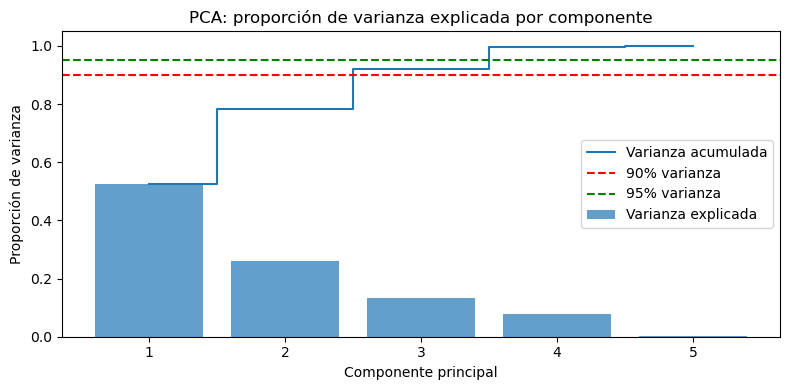

In [30]:
# Gráfico de varianza explicada (Scree plot)
plt.figure(figsize=(8,4))
plt.bar(pca_df["componente"], pca_df["varianza_explicada"], alpha=0.7, label="Varianza explicada")
plt.step(pca_df["componente"], pca_df["varianza_acumulada"], where="mid", label="Varianza acumulada")
plt.axhline(0.90, color="red", linestyle="--", label="90% varianza")
plt.axhline(0.95, color="green", linestyle="--", label="95% varianza")
plt.xlabel("Componente principal")
plt.ylabel("Proporción de varianza")
plt.title("PCA: proporción de varianza explicada por componente")
plt.legend()
plt.tight_layout()
plt.show()


A partir del análisis de la varianza explicada acumulada se observa que las tres primeras componentes concentran más del 90 % de la variabilidad total de los descriptores meteorológicos. En consecuencia, se seleccionan **3 componentes principales** como compromiso entre reducción de dimensionalidad y retención de información.


In [31]:
# Exploración de hiperparámetros en PCA
results = []
for whiten in [False, True]:
    for solver in ["auto", "full", "randomized"]:
        pca_cfg = PCA(n_components=3, whiten=whiten, svd_solver=solver, random_state=42)
        pca_cfg.fit(X_scaler)
        total_var = pca_cfg.explained_variance_ratio_.sum()
        results.append({
            "whiten": whiten,
            "svd_solver": solver,
            "varianza_total": total_var
        })

df_pca_hp = pd.DataFrame(results)
df_pca_hp


,whiten,svd_solver,varianza_total
0,False,auto,0.91909
1,False,full,0.91909
2,False,randomized,0.91909
3,True,auto,0.91909
4,True,full,0.91909
5,True,randomized,0.91909


Del experimento anterior se desprendió que los hiperparámetros `svd_solver` y `whiten` no tuvieron un impacto significativo sobre la proporción de varianza explicada en este dataset. Sin embargo, **`whiten=True`** puede amplificar el ruido y por ello se recomienda utilizar `whiten=False` para mantener la escala relativa de las componentes.


## 5.3) Determinación de variables que dominan los componentes principales

In [32]:
loadings = pd.DataFrame(
    pca_instance.components_,
    columns=X.columns,
    index=[f"p_{i}" for i in range(pca_instance.n_components_)]
)

loadings


,tavg,tmin,tmax,wspd,pres
p_0,0.601497,0.548259,0.542917,0.037326,-0.203623
p_1,-0.165237,0.084270,-0.190253,0.724852,-0.635601
p_2,0.080039,0.049166,0.088258,0.673741,0.727640


Debido al tamaño reducido del dataset (61 días) y a la naturaleza correlacionada de las variables meteorológicas, no existe un descriptor claramente dominante que explique por sí solo la ocurrencia de precipitación. Todas las variables aportan información, aunque en distinta magnitud. Las técnicas de reducción de dimensionalidad muestran que la estructura interna del dataset es difusa y no presenta una separación evidente entre días lluviosos y no lluviosos

## 6.1) t-SNE

In [33]:
tsne_instance = TSNE(random_state=42, n_components=3)
data_tsne = tsne_instance.fit_transform(X_scaler)
df_tsne = pd.DataFrame(data=data_tsne, columns=["p_0", "p_1", "p_2"])
df_tsne["label"] = y
df_tsne

,p_0,p_1,p_2,label
0,-112.213654,55.215675,9.772306,1
1,-56.129517,94.567062,72.748848,0
2,-46.578674,44.628304,117.450005,0
3,-109.198204,46.192112,-68.755257,0
4,84.540215,-35.068710,36.056580,1
...,...,...,...,...
56,87.496346,70.053032,101.752266,0
57,72.450073,-7.292568,-47.619362,1
58,95.374397,-87.833138,-67.592926,1
59,52.427937,-83.885597,-104.522186,0


<Axes: xlabel='p_0', ylabel='p_1'>

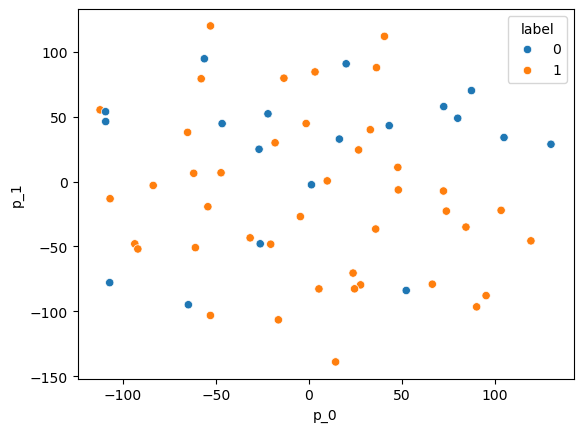

In [34]:
sns.scatterplot(data=df_tsne, x="p_0", y="p_1", hue="label")

<Axes: xlabel='p_0', ylabel='p_2'>

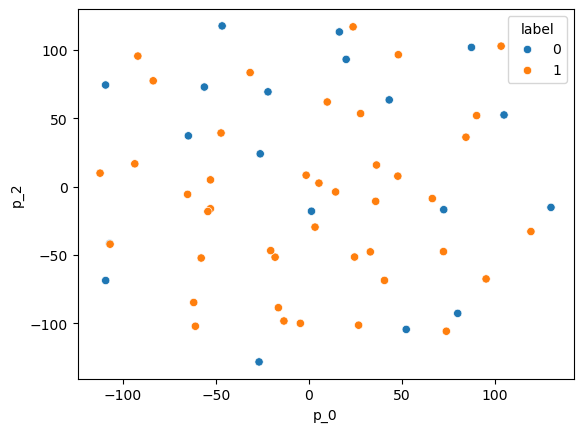

In [35]:
sns.scatterplot(data=df_tsne, x="p_0", y="p_2", hue="label")

<Axes: xlabel='p_1', ylabel='p_2'>

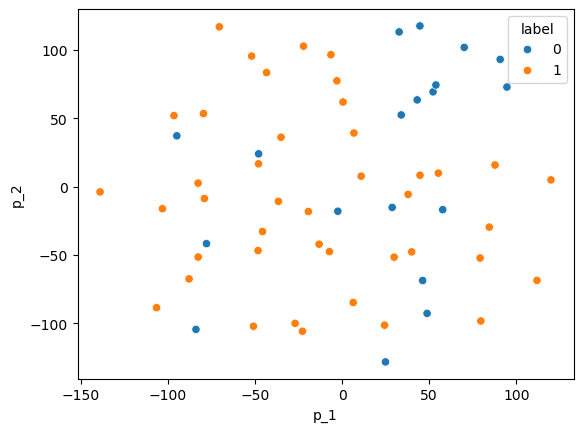

In [36]:
sns.scatterplot(data=df_tsne, x="p_1", y="p_2", hue="label")

## 6.2) Exploración de hiperparámetros en t‑SNE

Además de la configuración básica de t‑SNE utilizada anteriormente, se exploran distintas configuraciones del parámetro *perplexity* manteniendo la proyección en dos dimensiones. La _perplexity_ controla la atención que t‑SNE presta a las estructuras locales vs. globales del espacio original, por lo que su ajuste puede cambiar la distribución de los puntos en la proyección.


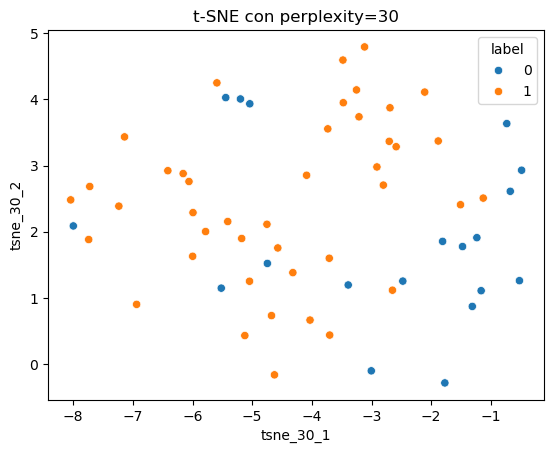

In [37]:
perplexities = [5, 30, 50]
tsne_embeddings = {}
for perplex in perplexities:
    tsne_model = TSNE(n_components=2, perplexity=perplex, random_state=42)
    embedding = tsne_model.fit_transform(X_scaler)
    df_tmp = pd.DataFrame(embedding, columns=[f"tsne_{perplex}_1", f"tsne_{perplex}_2"])
    df_tmp["label"] = y
    tsne_embeddings[perplex] = df_tmp

# Ejemplo de visualización para perplexity=30
sns.scatterplot(data=tsne_embeddings[30], x="tsne_30_1", y="tsne_30_2", hue="label")
plt.title("t‑SNE con perplexity=30")
plt.show()


Los gráficos obtenidos con diferentes valores de *perplexity* muestran que t‑SNE no revela _clusters_ claros por el label de precipitación; los puntos permanecen mezclados en las dos dimensiones obtenidas, lo cual sugiere que las variables meteorológicas seleccionadas no contienen patrones no lineales fuertes asociados a la presencia o ausencia de lluvia.


## 6.3) UMAP

Para complementar el estudio de técnicas de proyección no lineal, se aplica el algoritmo **UMAP (Uniform Manifold Approximation and Projection)**. Se exploran combinaciones de hiperparámetros como `n_neighbors` (número de vecinos utilizados para construir el grafo) y `min_dist` (distancia mínima entre puntos en la proyección). Al igual que en t‑SNE, la proyección se realiza en dos dimensiones para facilitar la visualización.


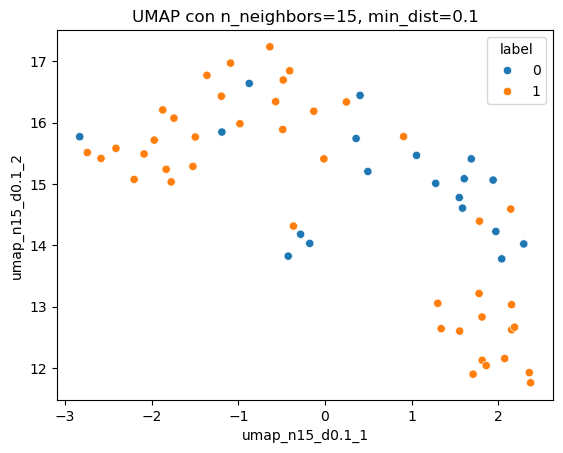

In [38]:
neighbors = [5, 15]
min_dists = [0.1, 0.5]
umap_embeddings = {}
for n in neighbors:
    for md in min_dists:
        umap_model = UMAP(n_components=2, n_neighbors=n, min_dist=md, random_state=42)
        embedding = umap_model.fit_transform(X_scaler)
        key = f"n{n}_d{md}"
        df_tmp = pd.DataFrame(embedding, columns=[f"umap_{key}_1", f"umap_{key}_2"])
        df_tmp["label"] = y
        umap_embeddings[key] = df_tmp

# Ejemplo de visualización para n_neighbors=15, min_dist=0.1
example_key = "n15_d0.1"
sns.scatterplot(data=umap_embeddings[example_key], x=f"umap_{example_key}_1", y=f"umap_{example_key}_2", hue="label")
plt.title("UMAP con n_neighbors=15, min_dist=0.1")
plt.show()


Al igual que con t‑SNE, las proyecciones generadas por UMAP no evidencian una separación clara entre los días con y sin precipitación. Las diferentes combinaciones de `n_neighbors` y `min_dist` generan distribuciones similares, confirmando que las variables disponibles no contienen patrones suficientes para discriminar el label.


## 6.4) Comparación y discusión de técnicas

- **PCA** es una técnica lineal que busca maximizar la varianza explicada. En este dataset las tres primeras componentes concentran más del 90% de la variabilidad, lo que reduce el espacio de cinco descriptores a tres sin una pérdida importante de información.
- **t‑SNE** y **UMAP** son técnicas no lineales que preservan relaciones de proximidad. Su principal objetivo es facilitar la visualización de datos de alta dimensión en dos o tres dimensiones. En los experimentos realizados no se observaron agrupaciones coherentes con la variable objetivo, lo que indica que las estructuras no lineales presentes en los descriptores meteorológicos no son suficientes para separar los días lluviosos de los no lluviosos.
- En términos cualitativos, **PCA** es útil para reducir la dimensionalidad y preparar los datos para modelos lineales; **t‑SNE** y **UMAP** son más adecuados para explorar la topología del espacio de datos. La elección de cada técnica depende del objetivo específico: reducción de dimensión para modelado o visualización para interpretación exploratoria.


## 7) Declaración de uso de IA

Se declara el uso de asistentes de inteligencia artificial — principalmente Copilot y ChatGPT — con el único propósito de apoyar la redacción de algunos bloques de texto _markdown_ y de asistir en la elaboración de ciertas partes del código (o también cuando yo intentaba hacer el código y cometía algún error que no sabía cómo solucionarlo).  Todo el contenido generado por estas herramientas fue posteriormente revisado, comprendido y validado por el autor.
